In [1]:
%matplotlib inline
from os.path  import join
import Packages.DataLoaders as loader
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import Packages.models as models

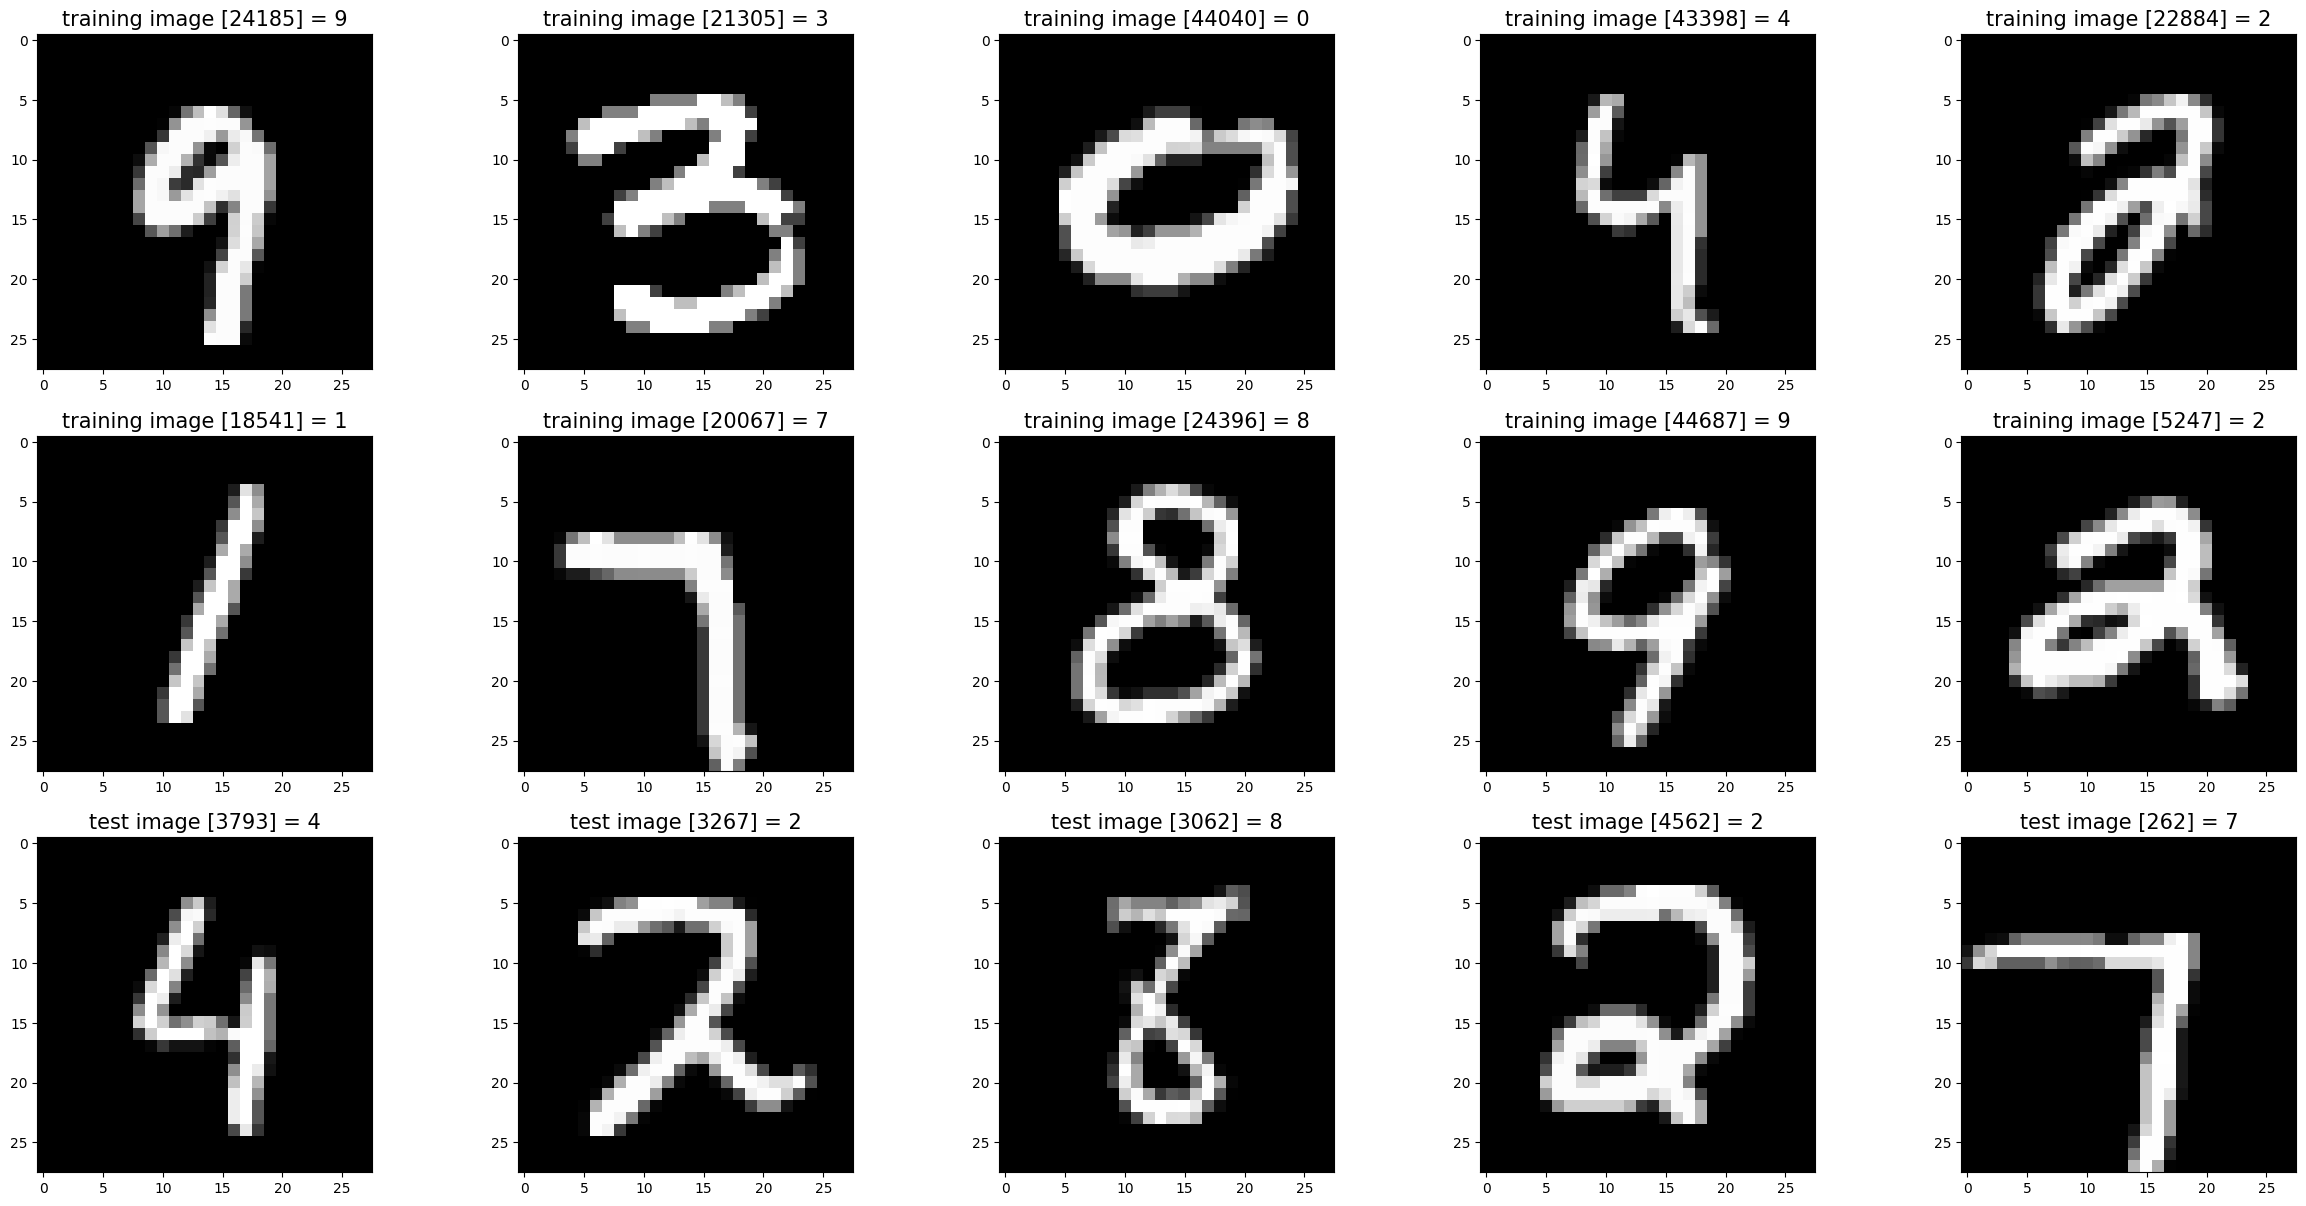

In [2]:

input_path = './Data'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Load MINST dataset
mnist_dataloader = loader.MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [3]:
font_loader = loader.FontDigitImageLoader(join(input_path,"Digits"))

In [4]:
font_images = font_loader.GetImages()
font_labels = font_loader.GetLabels()
x_train.extend(font_images)
y_train.extend(font_labels)

In [5]:
# Appending an empty image with 10 as label
x_train.append(np.zeros((28,28)))
y_train.append(10)
x_test.append(np.zeros((28,28)))
y_test.append(10)

# Change the weights so that the empty image becomes more important.
w = np.ones(11)
w[-1]=w[-1]*1000

In [6]:
len(x_train)

70161

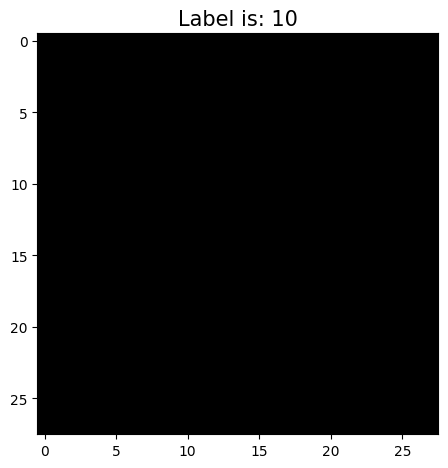

In [7]:
n=70160
show_images([np.array(x_train[n])],["Label is: "+str(y_train[n])])

In [8]:
# Convert NumPy arrays to PyTorch tensors
images_tensor = torch.stack([torch.from_numpy(img).float() for img in x_train])
labels_tensor = torch.from_numpy(np.array(y_train, dtype=int)).long()

# Create a custom dataset using TensorDataset
dataset = TensorDataset(images_tensor, labels_tensor)

# Create a DataLoader
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
def Test(model):
    # Testing the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total
def OneSeedProgram(i,epochs):
    # Set random seed
    torch.manual_seed(i)

    # Initialize the neural network, loss function, and optimizer
    model = models.ConvolutionalNN()
    criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor(w))
    # Define your optimizer with L2 regularization (weight decay)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
    #optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0
        for data in data_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(data_loader)}")
        acc = Test(model)
        print(f"Epoch {epoch + 1}/{epochs}, Accuracy on the test set: {acc * 100:.2f}%")
    acc = Test(model)
    print(f"Accuracy on the test set: {acc * 100:.2f}%")
    return (acc,model)

In [10]:
(score,model) = OneSeedProgram(7,24)

Epoch 1/24, Loss: 0.25831832943731237


KeyboardInterrupt: 

In [ ]:
(score,model) = OneSeedProgram(7,21)

In [ ]:
print(model.forward(torch.from_numpy(np.zeros((28,28))).float()))

In [ ]:
"""
# This is for when we want to run over multiple seeds
import Packages.priorityQueue as pq

q = pq.PriorityQueue(3)
for i in range(10):
    print("Seed number: "str(i))
    q.AddElement(OneSeedProgram(i,15))
print(q.getList())
"""

In [ ]:
# Testing how the model preforms on digits from a sudoku

input_path = './Data'

# Load the image
processor = loader.SudokuImageProcessor(join(input_path, "Sudokus/sudoku2.png"))
cropped_images_list = processor.digits(0.1)


In [ ]:
show_images([cropped_images_list[5][8]],["lala"])

In [ ]:
# From cropped images to integers
array = np.zeros((9, 9), dtype=int)
for i in range(9):
    for j in range(9):
        n = int(torch.argmax(model(torch.from_numpy(np.array(cropped_images_list[j][i])).float())).item())
        if n==10:
            array[j,i] = 0
        else:
            array[j,i] = n
        

In [ ]:
print(array)

In [ ]:
model(torch.from_numpy(np.array(cropped_images_list[0][3])).float())

In [ ]:
model.parameters

In [ ]:
import torch

# Example input tensor shape [64, 28, 28]
input_tensor = torch.randn(64, 28, 28)

# Add a channel dimension at the beginning
input_tensor = torch.unsqueeze(input_tensor, dim=1)

# Print the new shape of the tensor
print(input_tensor.shape)